In [1]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import git
import os, sys

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(os.path.join(path_git, 'utils'))
from functions_cosmo import *
from functions import *

os.chdir(path_git)



2024-11-12 13:50:47.155273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Los datos
Vamos a trabajar con datos de modulo de distancia de Supernovas tipo Ia, adquiridos a partir de la colaboración Pantheon Plus. Son datos de 1048 supernovas, con redshifts entre 0.01 y 2.26. Los datos se encuentran en el archivo 'Pantheon+SH0ES.dat'.



In [2]:
os.chdir(os.path.join(path_git, 'source','PPS'))
ds_SN_plus = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                        'covmat_pantheon_plus_only.npz')
os.chdir(path_git)

/home/mleize/Documents/Repos/final_exam_ML/functions_cosmo.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_pantheon_plus,delim_whitespace=True)


A partir de los datos de la magnitud aparente $m_b$, nos construimos los datos

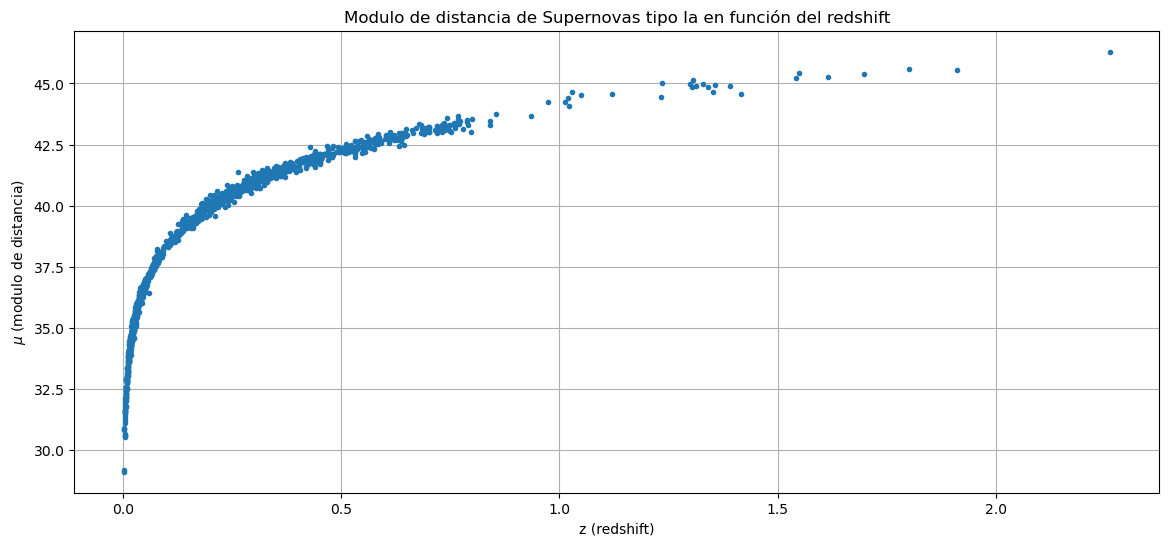

In [3]:
M_abs = -19.37 #Magnitud absoluta de las supernovas
zhd, _, _, mb = ds_SN_plus
muobs =  np.array(mb - M_abs)
zhd = np.array(zhd)

# Graficar la señal temporal
plt.figure(figsize=(14, 6))
plt.plot(zhd,muobs,'.')
plt.xlabel('z (redshift)')
plt.ylabel(r'$\mu$ (modulo de distancia)')
plt.title('Modulo de distancia de Supernovas tipo Ia en función del redshift')
plt.grid(True)
plt.show()

# El análisis preliminar
A modo de introducción, veamos un ejemplo de cómo podemos utilizar la metodología propuesta para analizar esta base de datos. Vamos a trabajar con los datos suavizados:

True


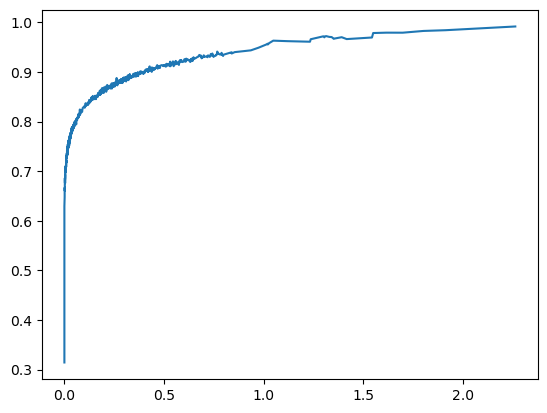

In [4]:
t = np.array(zhd)
raw_seq = np.array(muobs)/np.max(muobs)

len(raw_seq)
print(np.all(t == np.sort(t)))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

raw_seq = smooth(raw_seq, 2)
plt.plot(t,raw_seq)

In [5]:
# Parámetros de la simulación

# choose a number of time steps
look_back = 50

# Cantidad de valores por cada paso temporal
n_features = 1

# Cantidad de pasos que queremos predecir hacia adelante
window_size = 400

# longitud de la cadena izquierda
len_left_chain = 600

# longitud de la cadena derecha
len_right_chain = len(raw_seq) - len_left_chain - window_size

In [6]:
print(len_left_chain, len_right_chain)

600 657


In [7]:
raw_seq_1 = raw_seq[0:len_left_chain]
t_1 = t[0:len_left_chain]

print(len(raw_seq_1),len_left_chain)

600 600


In [8]:
raw_seq_2 = raw_seq[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]
t_2 = t[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(len(raw_seq_2),len_right_chain)

657 657


In [9]:
t_window = t[len_left_chain:len_left_chain+window_size]
raw_seq_window = raw_seq[len_left_chain:len_left_chain+window_size]
print(len(raw_seq_window),window_size)

400 400


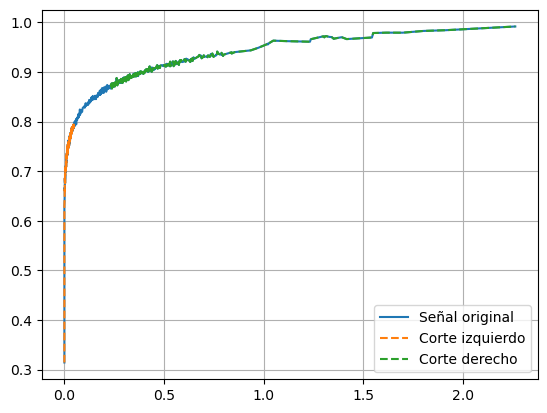

In [10]:
plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [11]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 0.00122 0.04985
t_window limits: 0.04989 0.2352
t_2 limits: 0.23556 2.26137
t limits: 0.00122 2.26137
len of times: 600 400 657 1657


In [12]:
predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

2024-11-11 13:11:40.846247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 14ms/step


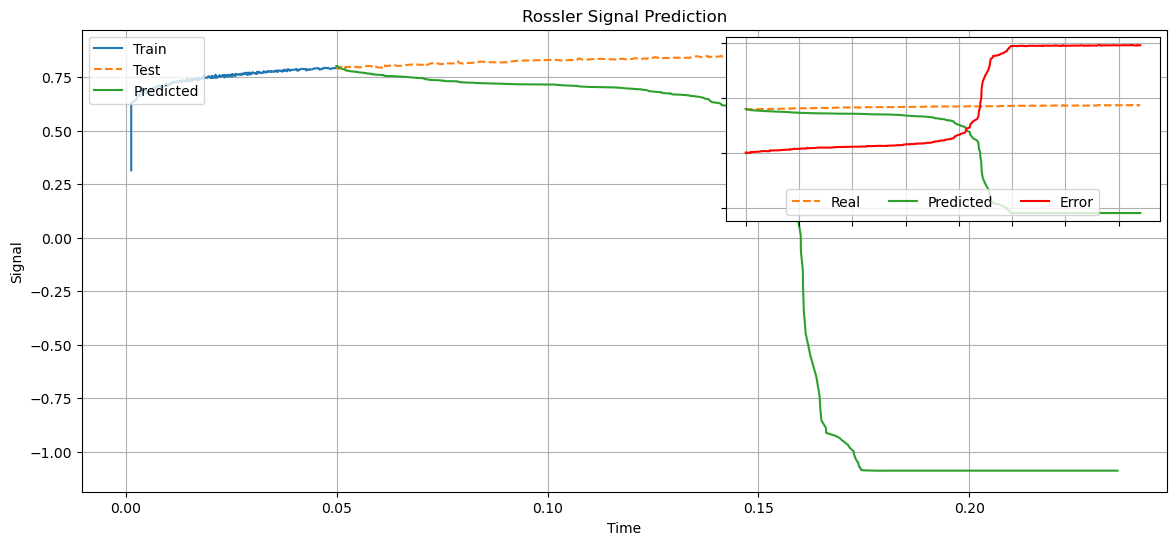

In [13]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_1, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_1, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()

In [14]:
predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1])
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

1/1 [==============================] - 0s 13ms/step


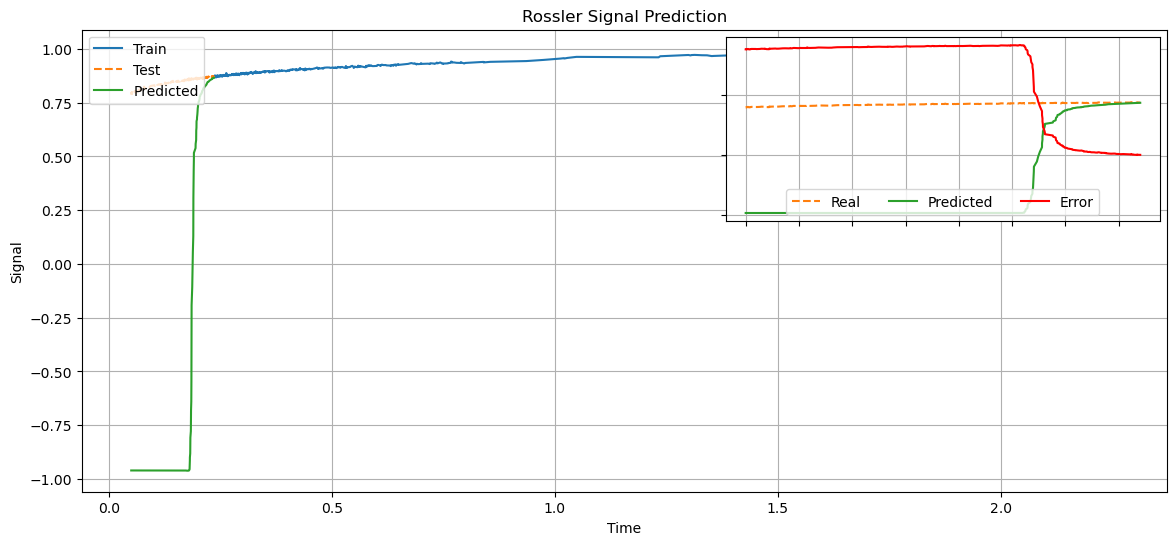

In [15]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_2,raw_seq_2,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_2,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_2, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_2, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()


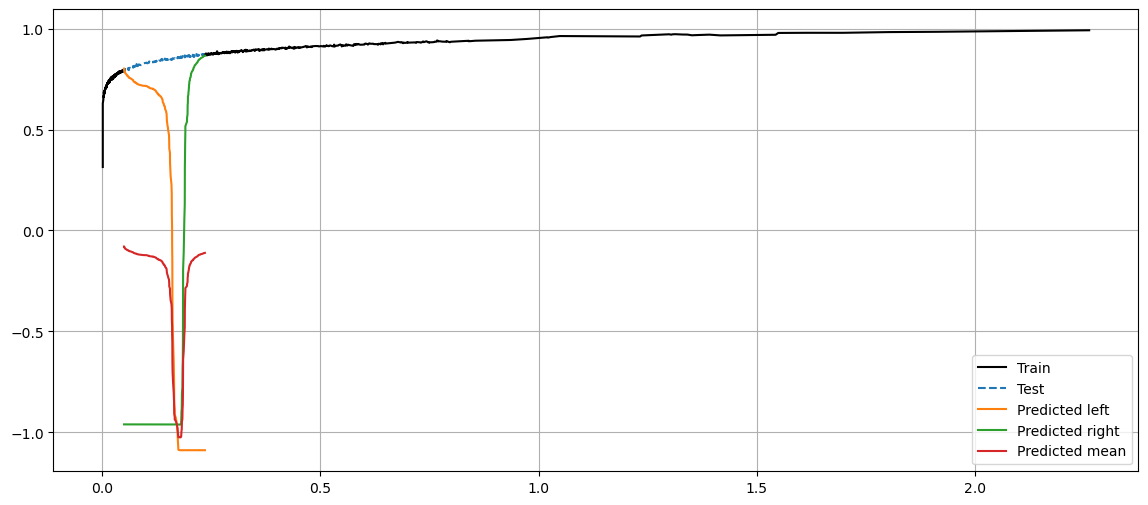

In [16]:
prediction_mean = (predicciones_adelante_1 + predicciones_adelante_2)/2


fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,'k',label='Train')
ax.plot(t_window,valores_reales_1,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted left')
ax.plot(t_2,raw_seq_2,'k')
ax.plot(t_window,predicciones_adelante_2,label='Predicted right')
ax.plot(t_window,prediction_mean,label='Predicted mean')
ax.grid()
ax.legend()
plt.show()
